# Demonstrating Metrics

In [1]:
%load_ext autoreload
%autoreload 2  

import os
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt


import sys
sys.path.append("..")

from modules.inference.model import Detector
from modules.inference.nms import NMS
from modules.utils.metrics import evaluate_detections, calculate_precision_recall_curve, calculate_map_x_point_interpolated

#### **Task 4: Assignment Instructions:**
A. Display the precision-recall curve for each of the classes.
B. Calculate the Average Precision of each class.
C. Measure the mAP of YOLO Model 1.

**Reminder:**  
- Your notebook should be well-structured and clear for effective presentation. Up to 10 points may be deducted for poor structure and clarity.
- Consider this report as if it were being reviewed by **TechTrack stakeholders**. Keep it professional, insightful, and visually organized!
- Use visualizations, tables, and quantitative analysis where applicable to support your findings.

---

### Initialize the required components and default parameters


In [2]:
## Initialize Model
WEIGHTS_PATH = "../storage/yolo_model_1/yolov4-tiny-logistics_size_416_1.weights"
CONFIG_PATH = "../storage/yolo_model_1/yolov4-tiny-logistics_size_416_1.cfg"
CLASS_NAMES_PATH = "../storage/yolo_model_1/logistics.names"
SCORE_THRESHOLD = 0.2

print("[INFO] Loading YOLO Model 1...")
detector = Detector(WEIGHTS_PATH, CONFIG_PATH, CLASS_NAMES_PATH, SCORE_THRESHOLD)
print("[INFO] Model loaded successfully.")

## Initialize NMS
IOU_THRESHOLD = 0.5
print("[INFO] Initializing Non-Maximum Suppression...")
nms = NMS(SCORE_THRESHOLD, IOU_THRESHOLD)
print("[INFO] NMS initialized.")

# Initialize default params
DATA_DIR = "../storage/logistics"
NUM_CLASSES = 20
MAP_IOU_THRESHOLD = 0.5

[INFO] Loading YOLO Model 1...
[INFO] Model loaded successfully.
[INFO] Initializing Non-Maximum Suppression...
[INFO] NMS initialized.


In [3]:
# Helper function to get annotation from given file_path
def get_annotations(file_path, img_height, img_width):
    bboxes = []
    class_labels = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            box = list(map(float, parts[1:]))
            box = box * np.array([img_width, img_height, img_width, img_height])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = tuple([x, y, int(width), int(height)])
            bboxes.append(box)
            
            class_label = int(parts[0])
            class_labels.append(class_label)
            

    return bboxes, class_labels

In [4]:
# Process image and annotation files for precision-recall curve
pred_bboxes, pred_class_ids, pred_confidence_scores, pred_class_scores = [], [], [], []
gt_boxes, gt_classes = [], []

for i, (image_file, annotation_file) in enumerate(zip(
                sorted(glob(os.path.join(DATA_DIR, "*.jpg"))),
                sorted(glob(os.path.join(DATA_DIR, "*.txt"))))):
    
    image = cv2.imread(image_file)
    img_height, img_width = image.shape[:2]

    # Get predictions
    raw_prediction = detector.predict(image)
    bboxes, class_ids, confidence_scores, class_scores = detector.post_process(raw_prediction)
    
    # Filter predictions with NMS
    filtered_bboxes, filtered_class_ids, filtered_scores, filtered_class_scores = nms.filter(bboxes, class_ids, confidence_scores, class_scores)
    filtered_bboxes = [tuple(b) for b in filtered_bboxes]

    pred_bboxes.append(filtered_bboxes)
    pred_class_ids.append(filtered_class_ids)
    pred_confidence_scores.append(filtered_scores)
    pred_class_scores.append(filtered_class_scores)

    # Get annotations
    gt_boxes.append(get_annotations(annotation_file, img_height, img_width)[0])
    gt_classes.append(get_annotations(annotation_file, img_height, img_width)[1])


# Generate precision recall curves
y_true, pred_scores = evaluate_detections(pred_bboxes, pred_class_ids, pred_confidence_scores, pred_class_scores, 
                                          gt_boxes, gt_classes, MAP_IOU_THRESHOLD, NUM_CLASSES, eval_type="class_scores"
                                          )
precision_dict, recall_dict, thresholds_dict = calculate_precision_recall_curve(y_true, pred_scores, NUM_CLASSES)

# # For each class, print the precision, recall, and threshold values.
# for cls in range(NUM_CLASSES):
#     print(f"\nClass {cls}:")
#     print("\tPrecision:", precision_dict[cls])
#     print("\tRecall:", recall_dict[cls])
#     print("\tThresholds:", thresholds_dict[cls])

#### **Task A:**
**Display the precision-recall curve for each of the classes.**

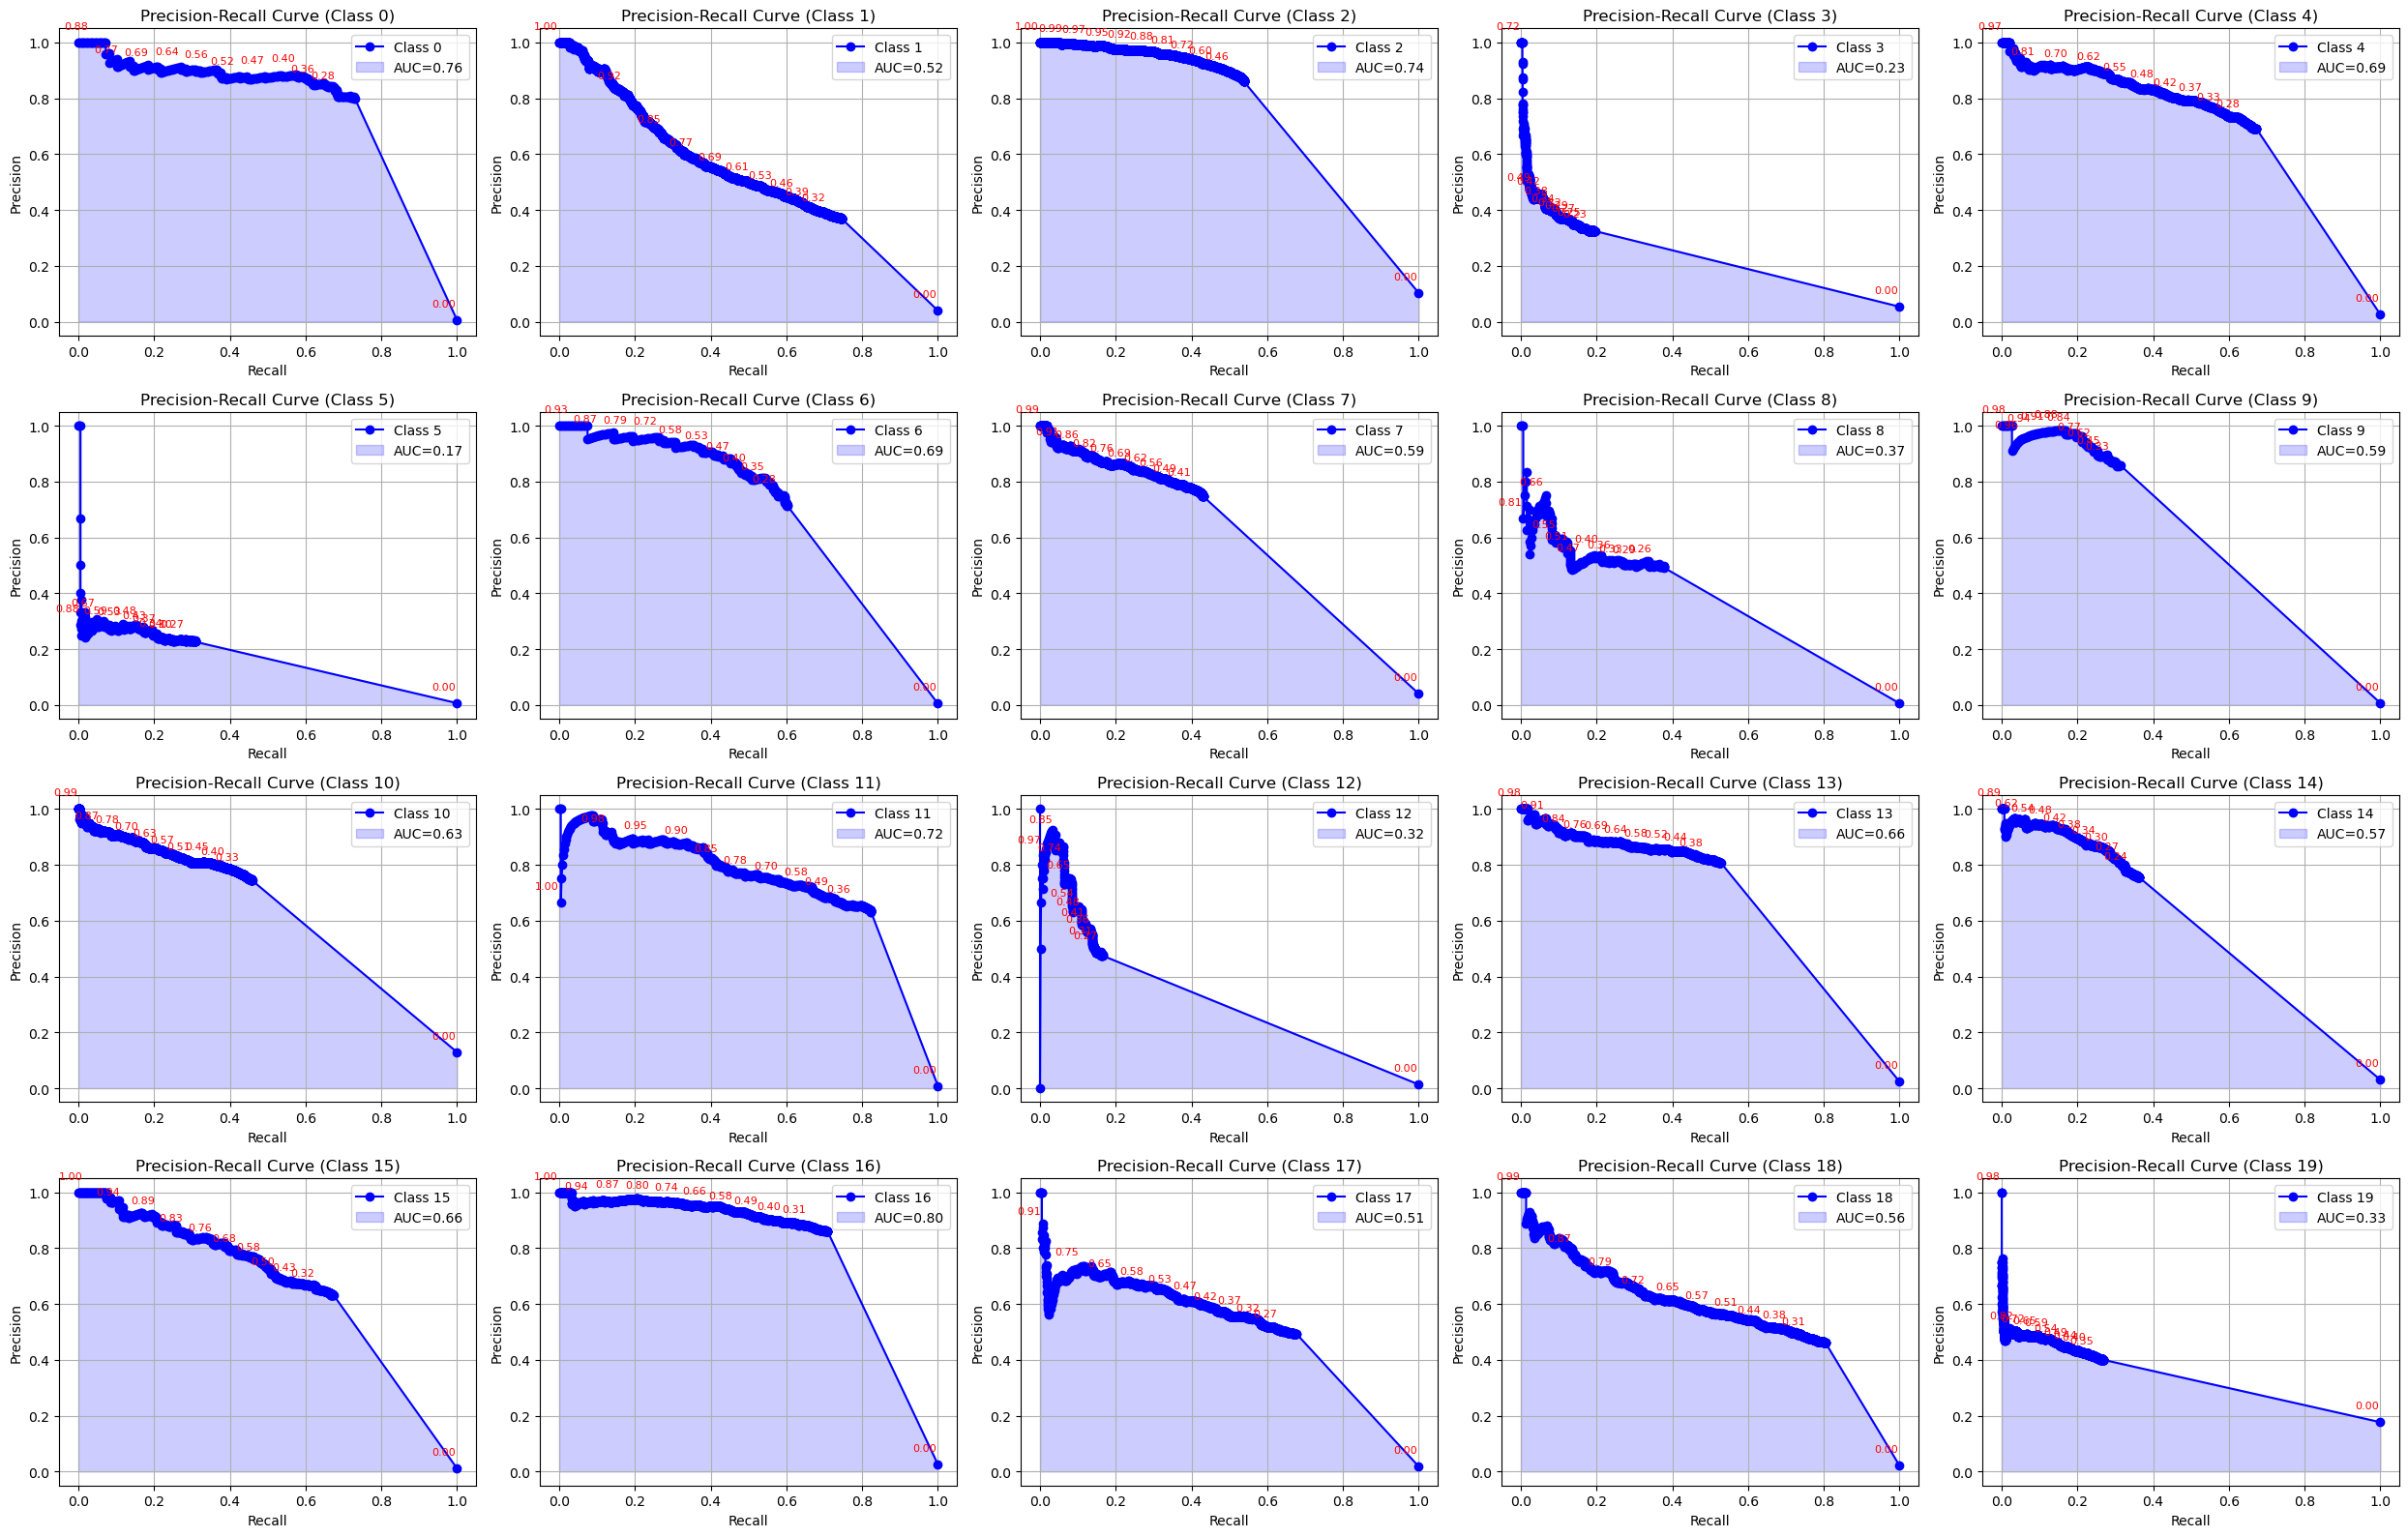

In [5]:
# Function to plot Precision-Recall curves for multiple classes as subplots.
def plot_precision_recall_curves(precision_dict, recall_dict, thresholds_dict):
    from sklearn.metrics import auc
    cols = 5
    rows = 4

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()  # Flatten in case of single row or column

    for i, class_id in enumerate(precision_dict.keys()):
        precisions = precision_dict[class_id]
        recalls = recall_dict[class_id]
        thresholds = thresholds_dict[class_id]
        pr_auc = auc(recalls, precisions)

        ax = axes[i]
        ax.plot(recalls, precisions, marker='o', label=f'Class {class_id}', color='b')
        ax.fill_between(recalls, precisions, alpha=0.2, color="b", label=f'AUC={pr_auc:.2f}')


        # Annotate some threshold values for reference
        for j in range(0, len(thresholds), max(1, len(thresholds) // 10)):  # Pick 10 threshold points
            ax.annotate(f'{thresholds[j]:.2f}', 
                        (recalls[j], precisions[j]), 
                        textcoords="offset points",
                        xytext=(-10,10),
                        ha='center',
                        fontsize=8,
                        color='red')

        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_title(f"Precision-Recall Curve (Class {class_id})")
        ax.legend()
        ax.grid(True)

    # Remove empty subplots if classes < total grid cells
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_precision_recall_curves(precision_dict, recall_dict, thresholds_dict)

**High-Performing Classes (Good PR Curves)**

Class 0, Class 2, Class 16 have smooth and well-distributed PR curves with high precision maintained across a wide range of recall values.
This suggests that the model has good confidence in predictions for these classes, achieving high precision even at moderate recall.

**Low-Performing Classes (Poor PR Curves)**

Class 3, Class 5, Class 17, and Class 19 show sharp drops in precision even at low recall values.
These indicate high false positive rates or difficulty in detecting these classes, which could stem from class imbalance, poor feature representation, or occlusions.

**Inconsistent Classes (Fluctuating PR Curves)**

Class 8 and Class 12 show fluctuating precision values, indicating possible misclassifications at different thresholds.
These classes might have overlapping features with others, making it difficult for the model to distinguish them accurately.


---

#### **Task B:**
**Calculate the Average Precision of each class.**

In [6]:
precision_recall_points = {
    class_index: list(zip(recall_dict[class_index], precision_dict[class_index]))
    for class_index in range(NUM_CLASSES)
}

mean_average_precisions, overall_map = calculate_map_x_point_interpolated(precision_recall_points, NUM_CLASSES, num_interpolated_points=11)
sorted_indices = np.argsort(np.array(mean_average_precisions))

# For each class, print the Average Precision
for cls in range(NUM_CLASSES):
    print(f"Class {cls}: Average Precision: {round(mean_average_precisions[cls], 4)}")

print("\n")
print(f"Top 3 class AP:")
print(f"\tClass: {[idx for idx in sorted_indices[-3:]]}, AP: {[round(mean_average_precisions[idx], 4) for idx in sorted_indices[-3:]]}")

print(f"Bottom 3 class AP: ")
print(f"\tClass: {[idx for idx in sorted_indices[:3]]}, AP: {[round(mean_average_precisions[idx], 4) for idx in sorted_indices[:3]]}")

Class 0: Average Precision: 0.6565
Class 1: Average Precision: 0.4849
Class 2: Average Precision: 0.5712
Class 3: Average Precision: 0.1688
Class 4: Average Precision: 0.5604
Class 5: Average Precision: 0.1655
Class 6: Average Precision: 0.5769
Class 7: Average Precision: 0.4201
Class 8: Average Precision: 0.2444
Class 9: Average Precision: 0.351
Class 10: Average Precision: 0.4671
Class 11: Average Precision: 0.6744
Class 12: Average Precision: 0.1611
Class 13: Average Precision: 0.4965
Class 14: Average Precision: 0.3524
Class 15: Average Precision: 0.5423
Class 16: Average Precision: 0.6927
Class 17: Average Precision: 0.4402
Class 18: Average Precision: 0.5418
Class 19: Average Precision: 0.3024


Top 3 class AP:
	Class: [0, 11, 16], AP: [0.6565, 0.6744, 0.6927]
Bottom 3 class AP: 
	Class: [12, 5, 3], AP: [0.1611, 0.1655, 0.1688]


The result above shows there are variations of AP values across classes.

* The high AP values indicate that the model is effectively detecting these objects while maintaining a low false positive rate.
* These classes with low AP values have low detection quality, meaning the model struggles to maintain high precision and recall.

---

#### **Task C:**
**Measure the mAP of YOLO Model 1.**

In [7]:
print(f"Overall mAP of YOLO Model 1: {round(overall_map, 4)}")

Overall mAP of YOLO Model 1: 0.4435


Based on the current settings, the overall mAP for YOLO Model 1 is 0.4435. It can be further improved to strengthen the training on certain low-performing classes, such as:
* increasing dataset size for underperforming classes
* augmenting difficult classes with transformations, occlusions, and synthetic data.
* hard negative mining to focus on common false positives.

In addition, the model can be further tuned for better hyperparameter settings such as SCORE_THRESHOLD and IOU_THRESHOLD for model and NMS.